<h1>Model to predict airport flight delays</h1>

Much of this model is taken from the work of Fabien Daniel:
https://www.kaggle.com/code/fabiendaniel/predicting-flight-delays-tutorial/notebook.  
The difference here is that we are modeling delays for all arrival airports and all airlines given a single departure airport.

We also incorporate MLflow tracking using the Python API.  

Input parameters for this script include:
* num_alpha_increments:  The number of different Ridge regression alpha penalty values to try, spaced by 0.2 apart
  
Dependencies:
* cleaned_data.csv is the input data file, structured appropriately.  The structure of this data file must be:

Outputs:
* log file named "polynomial_regression.txt" containing information about the model training process
* MLFlow experiment named with current date containing model training runs, one for each value of the Ridge regression penalty

| YEAR | MONTH | DAY | DAY_OF_WEEK | ORG_AIRPORT | DEST_AIRPORT | SCHEDULED_DEPARTURE | DEPARTURE_TIME | DEPARTURE_DELAY | SCHEDULED_ARRIVAL | ARRIVAL_TIME | ARRIVAL_DELAY |
|:--------:|:--------:|:--------:|:--------:|:--------:|:--------:|:--------:|:--------:|:--------:|:--------:|:--------:|:--------:|
| integer | integer | integer | integer | string | string | integer | integer | integer | integer | integer | integer |


In [2]:
# Here we import the packages we will need
import datetime
import pandas as pd
import argparse
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import PolynomialFeatures, LabelEncoder, OneHotEncoder
from sklearn import metrics, linear_model
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
import mlflow
import mlflow.sklearn
import logging
import os
import pickle
import json

In [3]:
# set up the argument parser
parser = argparse.ArgumentParser(description='Parse the parameters for the polynomial regression')
parser.add_argument('num_alphas', metavar='N', type=int, help='Number of Lasso penalty increments')
order = 1
#args = parser.parse_args()
#num_alpha_increments = args[0]
# Uncomment the two lines above and comment the line below to run this script from the command prompt or as part of an 
# MLFlow pipeline
num_alphas = 20

In [4]:
# configure logger
logname = "polynomial_regression.txt"
logging.basicConfig(filename=logname,
                    filemode='w',
                    format='%(asctime)s %(levelname)s %(message)s',
                    datefmt='%H:%M:%S',
                    level=logging.DEBUG)
logging.getLogger('matplotlib.font_manager').disabled = True
logging.info("Flight Departure Delays Polynomial Regression Model Log")

In [5]:
# read the data file
df = pd.read_csv("cleaned_data.csv")
tab_info=pd.DataFrame(df.dtypes).T.rename(index={0:'column type'})

In [6]:
def grab_month_year(df:pd.DataFrame) -> tuple:
    """
    grab_month_year is a function to extract the month and year of the flights in the departure delay dataset.

    Parameters
    ----------
    df : pd.DataFrame
        the input data set in Pandas data frame format.

    Returns
    -------
    tuple
        (month,year) of the data set.

    Raises
    ------
    Exception
        If more than one month or year are found in the data set.
    """
    months = pd.unique(df['MONTH'])
    years = pd.unique(df['YEAR'])
    if len(months) >1:
        raise Exception("Multiple months found in data set, only one acceptable")
    else:
        month = int(months[0])
    if len(years) > 1:
        raise Exception("Multiple years found in data set, only one acceptable")
    else:
        year = int(years[0])
    return (month, year)

In [7]:
def format_hour(string: str) -> datetime:
    """
    format_hour is a function to convert an 'HHMM' string input to a time in datetime format.

    Parameters
    ----------
    string : string
        An hour and minute in 'HHMM' format.

    Returns
    -------
    datetime
        An hour and minute (datetime.time).  Returns nan if input string is null.

    """    
    if pd.isnull(string):
        return np.nan
    else:
        if string == 2400: string = 0
        string = "{0:04d}".format(int(string))
        hour = datetime.time(int(string[0:2]), int(string[2:4]))
        return hour

def combine_date_hour(x: list) -> datetime:
    """
    combine_date_hour is a function that combines a date and time to produce a datetime.datetime

    Parameters
    ----------
    x : list
        A list containing a date and a time in datetime format.

    Returns
    -------
    datetime
        A combined date and time in datetime format. Returns nan if time is null.

    """
    if pd.isnull(x.iloc[0]) or pd.isnull(x.iloc[1]):
        return np.nan
    else:
        return datetime.datetime.combine(x.iloc[0],x.iloc[1])


def create_flight_time(df: pd.DataFrame, col: str) -> pd.Series:
    """
    create_flight_time is a function that combines two columns of a data frame to produce a datetime.datetime series.

    Parameters
    ----------
    df : pd.DataFrame
        A data frame containing flight departure delay data
    col: string
        The name of one of the columns in the data frame containing flight departure delay data

    Returns
    -------
    pd.Series
        A Pandas series of datetimes with combined date and time

    """
    list = []
    for index, cols in df[['DATE', col]].iterrows():
        if pd.isnull(cols.iloc[1]):
            list.append(np.nan)
        elif float(cols.iloc[1]) == 2400:
            cols.iloc[0] += datetime.timedelta(days=1)
            cols.iloc[1] = datetime.time(0,0)
            list.append(combine_date_hour(cols))
        else:
            cols.iloc[1] = format_hour(cols.iloc[1])
            list.append(combine_date_hour(cols))
    return pd.Series(list)

In [8]:
def create_df(df: pd.DataFrame) -> pd.DataFrame:
    """
    create_df is a function that wrangles data within a flight departure delay data frame into the format needed for ML training.

    Parameters
    ----------
    df : pd.DataFrame
        A data frame containing flight departure delay data

    Returns
    -------
    pd.DataFrame
        A Pandas data frame with modified columns and data formats suitable for regression model training

    """
    df2 = df[['SCHEDULED_DEPARTURE','SCHEDULED_ARRIVAL',
                                    'DEST_AIRPORT','DEPARTURE_DELAY']]
    df2 = df2.dropna(how = 'any')
    df2.loc[:,'weekday'] = df2['SCHEDULED_DEPARTURE'].apply(lambda x:x.weekday())
    #____________________
    # delete delays > 1h
    df2.loc[:,'DEPARTURE_DELAY'] = df2['DEPARTURE_DELAY'].apply(lambda x:x if x < 60 else np.nan)
    df2 = df2.dropna(how = 'any')
    #_________________
    # formating times
    fct = lambda x:x.hour*3600+x.minute*60+x.second
    df2.loc[:,'hour_depart'] = df2['SCHEDULED_DEPARTURE'].apply(lambda x:x.time())
    df2.loc[:,'hour_depart'] = df2['hour_depart'].apply(fct)
    df2.loc[:,'hour_arrive'] = df2['SCHEDULED_ARRIVAL'].apply(fct)
    df2 = df2[['hour_depart','hour_arrive',
            'DEST_AIRPORT','DEPARTURE_DELAY','weekday']]
    df3 = df2.groupby(['hour_depart', 'hour_arrive', 'DEST_AIRPORT'],
                      as_index = False).mean()
    return df3

In [9]:
nowdate = datetime.date.today()
# creates an experiment name that changes every day
experiment_name = "Airport Departure Delays, experiment run on " + str(nowdate)
# creates new experiment if there is not one yet today, otherwise sets the experiment to the existing one for today
experiment = mlflow.set_experiment(experiment_name)
run_name = "Run started at " + datetime.datetime.now().strftime("%H:%M")
    

In [10]:
df['DATE'] = pd.to_datetime(df[['YEAR','MONTH', 'DAY']])
(month,year) = grab_month_year(df)
logging.info("Month and year of data: %s %s", month, year)
df['SCHEDULED_DEPARTURE'] = create_flight_time(df, 'SCHEDULED_DEPARTURE')
df['DEPARTURE_TIME'] = df['DEPARTURE_TIME'].apply(format_hour)
df['SCHEDULED_ARRIVAL'] = df['SCHEDULED_ARRIVAL'].apply(format_hour)
df['ARRIVAL_TIME'] = df['ARRIVAL_TIME'].apply(format_hour)

In [11]:
# define training data as the first 3 weeks of the month, and test data as that from the fourth week of the month
df_train = df[df['SCHEDULED_DEPARTURE'].apply(lambda x:x.date()) < datetime.date(year, month, 23)]
df_test  = df[df['SCHEDULED_DEPARTURE'].apply(lambda x:x.date()) > datetime.date(year, month, 23)]

In [12]:
df3 = create_df(df_train)

In [13]:
# perform one-hot encoding of all destination airports in training data
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(df3['DEST_AIRPORT'])
#_________________________________________________________
zipped = zip(integer_encoded, df3['DEST_AIRPORT'])
label_airports = list(set(list(zipped)))
label_airports.sort(key = lambda x:x[0])
#_________________________________________________
onehot_encoder = OneHotEncoder(sparse_output=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
#_________________________________________________
b = np.array(df3[['hour_depart', 'hour_arrive']])
X = np.hstack((onehot_encoded, b))
Y = np.array(df3['DEPARTURE_DELAY'])
Y = Y.reshape(len(Y), 1)
logging.info("Airport one-hot encoding successful")

In [14]:
# train/validation split at 30%
X_train, X_validate, Y_train, Y_validate = train_test_split(X, Y, test_size=0.3)

In [15]:
with mlflow.start_run(experiment_id = experiment.experiment_id, run_name=run_name):
    score_min = 10000
    alpha_max = num_alphas * 2
    count = 1
    # loop through all alpha values
    for alpha in range(0, alpha_max, 2):
        run_num = "Training Run Number " + str(count)
        # create a Ridge regressor with the stated alpha
        ridgereg = Ridge(alpha = alpha/10)
        # create polynomial features based on the polyniomial order
        poly = PolynomialFeatures(degree = order)
        # fit the model using the training data
        X_ = poly.fit_transform(X_train)
        ridgereg.fit(X_, Y_train)
        X_ = poly.fit_transform(X_validate)
        # predict against the validation data
        result = ridgereg.predict(X_)
        # how well did the model do when compared to the validation actuals?
        score = metrics.mean_squared_error(result, Y_validate)
        with mlflow.start_run(run_name = run_num,nested=True):
            mlflow.log_param("alpha",alpha/10)
            mlflow.log_metric("Training Data Mean Squared Error",score)
            mlflow.log_metric("Training Data Average Delay",np.sqrt(score))
        if score < score_min:
            score_min = score
            parameters = [alpha, order]
        logging.info("n={} alpha={} , MSE = {:<0.5}".format(order, alpha/10, score))
        count +=1
    # train and predict on validation data with optimal alpha found
    X_ = poly.fit_transform(X_validate)
    tresult = ridgereg.predict(X_)
    tscore = metrics.mean_squared_error(tresult, Y_validate)
    logging.info('Training Data Final MSE = {}'.format(round(tscore, 2)))
    mlflow.log_metric("Training Data Mean Squared Error",tscore)
    mlflow.log_metric("Training Data Average Delay",np.sqrt(tscore))
mlflow.end_run()
logging.info("Model training loop completed with %s iterations", count-1)

In [16]:
# create a data frame of the test data
df3 = create_df(df_test)

label_conversion = dict()
for s in label_airports:
    label_conversion[s[1]] = int(s[0])

# export airport label conversion for test data to json file for later use
jsonout = json.dumps(label_conversion)
f = open("airport_encodings.json","w")

# write json object to file
f.write(jsonout)

# close file
f.close()
logging.info("Export of airport one-hot encoding successful")
df3.loc[:,'DEST_AIRPORT'] = df3.loc[:,'DEST_AIRPORT'].map(pd.Series(label_conversion))

# manually one-hot encode destination airports for test data
for index, label in label_airports:
    temp = df3['DEST_AIRPORT'] == index
    temp = temp.apply(lambda x:1.0 if x else 0.0)
    if index == 0:
        matrix = np.array(temp)
    else:
        matrix = np.vstack((matrix, temp))
matrix = matrix.T

b = np.array(df3[['hour_depart', 'hour_arrive']])
X_test = np.hstack((matrix, b))
Y_test = np.array(df3['DEPARTURE_DELAY'])
Y_test = Y_test.reshape(len(Y_test), 1)
logging.info("Wrangling of test data successful")

In [17]:
# create polynomial features based on order
X_ = poly.fit_transform(X_test)
# predict on last week of month data
result = ridgereg.predict(X_)
score = metrics.mean_squared_error(result, Y_test)
logging.info('Test Data MSE = {}'.format(round(score, 2)))
logging.info("Predictions using test data successful")

In [18]:
logging.info('Test Data average delay = {:.2f} min'.format(np.sqrt(score)))

In [19]:
# export final model
filename = 'finalized_model.pkl'
pickle.dump(ridgereg, open(filename, 'wb'))
logging.info("Final model export successful")

C:\Users\remsteele\AppData\Local\Temp\ipykernel_16024\4029917953.py:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  tips["prediction"] = pd.Series([float(s) for s in result])


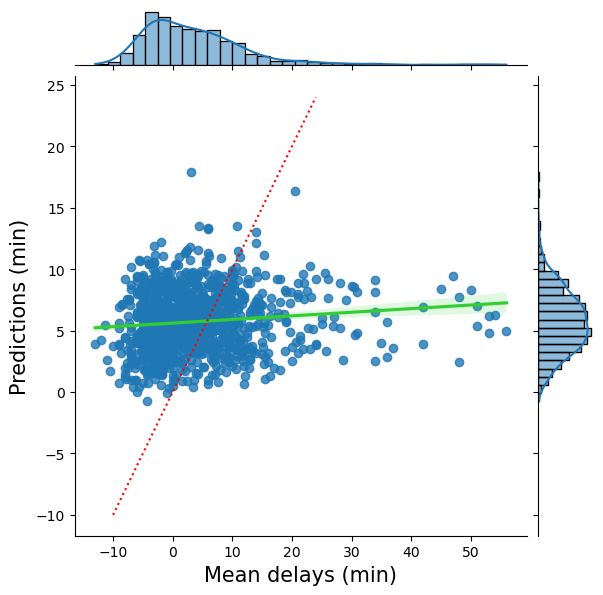

In [21]:
# create and export model performance plot
tips = pd.DataFrame()
tips["prediction"] = pd.Series([float(s) for s in result]) 
tips["original_data"] = pd.Series([float(s) for s in Y[:,0]]) 
sns.jointplot(x="original_data", y="prediction", data=tips, height = 6, ratio = 7,
              joint_kws={'line_kws':{'color':'limegreen'}}, kind='reg')
plt.xlabel('Mean delays (min)', fontsize = 15)
plt.ylabel('Predictions (min)', fontsize = 15)
plt.plot(list(range(-10,25)), list(range(-10,25)), linestyle = ':', color = 'r')
plt.savefig("model_performance_test.jpg",dpi=300)
logging.info("Model performance plot export successful")

In [23]:
import mlflow
import mlflow.sklearn
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

#  Ensure any active MLFlow run is ended before starting a new one
if mlflow.active_run():
    mlflow.end_run()

# Explicitly set the experiment
mlflow.set_experiment("Airport_Delay_Prediction")

# Retrieve the experiment again to avoid ID mismatches
experiment = mlflow.get_experiment_by_name("Airport_Delay_Prediction")

# Define hyperparameter grid
alpha_values = [0.001, 0.01, 0.1, 1, 10]

with mlflow.start_run(experiment_id = experiment.experiment_id, run_name = "Final Model - Test Data"):
    # input parameters
    mlflow.log_param("alpha", parameters[0]/10)
    mlflow.log_param("polynomial_order", order)
    
    # performance metrics
    mlflow.log_metric("RMSE", np.sqrt(score))
    mlflow.log_metric("MSE", score)
    mlflow.log_metric("mean_delay_minutes", np.mean(np.abs(result - Y_test)))
    
    # Transform input example using polynomial features
    input_example = X_test[0:2]  # Take first two rows as example
    input_example_transformed = poly.transform(input_example)
    
    # Create signature using transformed features
    signature = mlflow.models.infer_signature(
        input_example_transformed,  # Input example after polynomial transformation
        result[0:2]                # Corresponding outputs
    )
    
    mlflow.sklearn.log_model(
        ridgereg, 
        "model",
        signature=signature,
        input_example=input_example_transformed
    )
    mlflow.log_artifact("model_performance_test.jpg")
    mlflow.log_artifact("polynomial_regression.txt")

mlflow.end_run()


2025/02/16 16:29:14 INFO mlflow.tracking.fluent: Experiment with name 'Airport_Delay_Prediction' does not exist. Creating a new experiment.


In [25]:
logging.shutdown()